# Louis Atallah
# LinkedIn Web Scraper
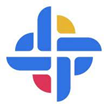

In [110]:
import random
import argparse
import requests
import re
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import time as t
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import urllib



# PART 1: Webscrapping data from LinkedIn

### Class implemented to get the weblinks of employees profiles with their names and labels.

In [111]:
class LinkedinScraper(object):
  def __init__(self, keyword, limit):
      """
      param keyword: a str of keyword(s) to search for (here the name of the company - Hubspot)
      param limit: number of profiles to scrape
      """
      self.keyword = keyword.replace(' ', '%20')
      self.all_htmls = ""
      self.quantity = '100'
      self.limit = int(limit)
      self.counter = 0
    
  def search(self):
        """
        perform the search
        return a list of htmls from Google Searches
        """
        # choose a random user agent
        user_agents = [
            'Mozilla/5.0 (Windows NT 6.2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/28.0.1464.0 Safari/537.36',
            'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0) chromeframe/10.0.648.205',
            'Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1500.55 Safari/537.36',
            'Mozilla/5.0 (Windows NT 6.2) AppleWebKit/536.6 (KHTML, like Gecko) Chrome/20.0.1090.0 Safari/536.6',
            'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/535.19 (KHTML, like Gecko) Ubuntu/11.10 Chromium/18.0.1025.142 Chrome/18.0.1025.142 Safari/535.19',
            'Mozilla/5.0 (Windows NT 5.1; U; de; rv:1.9.1.6) Gecko/20091201 Firefox/3.5.6 Opera 11.00'
        ]
        while self.counter < self.limit:
            headers = {'User-Agent': random.choice(user_agents)}        # random user agent selected
            url = 'http://google.com/search?num=100&start=' + str(self.counter) + '&hl=en&meta=&q=site%3Alinkedin.com/in%20' + self.keyword
            resp = requests.get(url, headers=headers)
            if ("Our systems have detected unusual traffic from your computer network.") in resp.text:
                print("Running into captchas")
                return

            self.all_htmls += resp.text
            self.counter += 100
            
  def parse_links(self):
    """
    collect the profile links
    return a list of links
    """
    
    reg_links = re.compile(r"url=https:\/\/www\.linkedin.com(.*?)&")
    self.temp = reg_links.findall(self.all_htmls)
    results = []
    for regex in self.temp:
      final_url = regex.replace("url=", "")
      results.append("https://www.linkedin.com" + final_url)
    return results
    
    
  def parse_people(self):
    """
    param html: parse the html for Linkedin Profiles using regex
    return a list of employees with their names and their labels
    """
    
    reg_people = re.compile(r'">[a-zA-Z0-9._ -]* -|\| LinkedIn')
    self.temp = reg_people.findall(self.all_htmls)
    print(self.temp)
    results = []
    for iteration in (self.temp):
        delete = iteration.replace(' | LinkedIn', '')
        delete = delete.replace(' - LinkedIn', '')
        delete = delete.replace(' profiles ', '')
        delete = delete.replace('LinkedIn', '')
        delete = delete.replace('"', '')
        delete = delete.replace('>', '')
        delete = delete.strip("-")
        delete = delete.strip('| ')
        
        if delete != " " and delete != "":
            results.append(delete)
    return results

# LinkedIn Login

In [112]:
option = webdriver.ChromeOptions()
option.add_argument("--incognito")
option.add_argument("lan=eng")

In [113]:
driver = webdriver.Chrome("./chromedriver", options=option)


In [114]:
def login():
    """
    
    Function to get  to the login page and sign in 
    """
    driver.get("https://www.linkedin.com/")

    email = input("email/cell phone: ")
    password = input("password: ")

    username = driver.find_element_by_id("session_key")
    passw = driver.find_element_by_id("session_password")
    username.send_keys(email)
    passw.send_keys(password)

    element = driver.find_element_by_class_name("sign-in-form__submit-button")
    try :
        element.click()
    except Exception as e :
        print(e)

In [115]:
login()

email/cell phone: mimilamomie1995@gmail.com
password: mimilamomie


# Hubspot Webpage


In [116]:
driver.get("https://www.linkedin.com/company/hubspot/people/")

## LinkedIn Scrapping

In [117]:
ls = LinkedinScraper(keyword="Hubspot",limit=300)
ls.search()
links = ls.parse_links()
profiles = ls.parse_people()

['">Dharmesh Shah - Founder and CTO - HubSpot -', '">Scott Brinker - VP Platform Ecosystem - HubSpot -', '">Nataly Kelly -', '">Sam Shoolman - Senior Director of Corporate Sales -', '">Brian Halligan - Executive Chairperson -', '| LinkedIn', '">Kyle Jepson - Senior Inbound Sales Professor - HubSpot -', '">Chris Hogan - VP Corporate Strategy -', '| LinkedIn', '">Kieran Flanagan - Senior Vice President Marketing -', '">Katie Burke - Chief People Officer -', '| LinkedIn', '">Rachel Leist - Senior Director of Marketing at HubSpot -', '">Hannah Fleishman -', '">Karla Cook Hesterberg -', '">Dan Tyre - Executive -', '| LinkedIn', '">Kipp Bodnar - CMO - HubSpot -', '">Jeetu Mahtani -', '">Rob Giglio - Chief Customer Officer - HubSpot -', '">Christopher Miller -', '">Morgan Jacobson -', '">Max Cohen - Senior Solutions Engineer -', '| LinkedIn', '">Alison Elworthy -', '">Ryan Beale -', '">Justin Champion - Head of Link Building -', '| LinkedIn', '">Andrew Pitre -', '| LinkedIn', '">Amanda Sibley

### Dataframe 


In [118]:
dataset = pd.DataFrame(columns=['firstname','lastname','label','location','profile_picture'])
dataset

,firstname,lastname,label,location,profile_picture


### Scrapping the data from LinkedIn


In [119]:
for i in range(0,250,1) : 
    profile = profiles[i].split(" - ")
    name = profile[0].split()
    firstname = name[0]
    
    try:
        lastname = name[1]     
    except :
        lastname = None
        
    if " - " in profiles[i] :
        label = " - ".join(profiles[i].split(" - ")[1:])
    else : 
        label = None
        
    driver.get(links[i])
    
    # location
    try : 
        location = driver.find_element_by_xpath("//*[@class='text-body-small inline t-black--light break-words'][last()]").text
    except : 
        driver.get("https://www.linkedin.com/")
        driver.get(links[i])
        
    # image
    try : 
        profile_picture = driver.find_element_by_xpath("//*[@class='pv-top-card-profile-picture__image pv-top-card-profile-picture__image--show ember-view'][last()]").get_attribute('src')
    except :
        profile_picture = None
        
    df = pd.DataFrame([[firstname,lastname,label,location,profile_picture]],columns=['firstname','lastname','label','location','profile_picture'])
    # concatenate the new data with the main dataframe
    dataset = pd.concat([dataset,df], ignore_index=True)  
    
    

KeyboardInterrupt: 

### Drop duplicated rows

In [93]:
dataset = dataset.drop_duplicates(keep='first')

### Drop rows with Nas as first name, last name, or as profile picture


In [94]:
dataset = dataset.dropna(subset=['firstname','lastname','profile_picture'])

In [95]:
dataset.shape

(10, 5)

### Function to drop a certain amount of rows according to their index

In [96]:
def reduce(lim) :
    """
    return index with nan values
    """
    rows_with_nan = []
    for index, row in dataset.iterrows():
        is_nan_series = row.isnull()
        if is_nan_series.any():
            rows_with_nan.append(index)
    rows_with_nan = rows_with_nan[:lim]        
    return rows_with_nan

### If the data frame has over 200 rows

In [97]:
if dataset.shape[0] > 200 : 
    index = reduce(dataset.shape[0] - 200)
    index
    dataset = dataset.drop(labels=index, axis=0)

In [98]:
dataset.sample(5)

,firstname,lastname,label,location,profile_picture
5,Sam,Shoolman,Senior Director of Corporate Sales,"Boston, Massachusetts, United States",https://media-exp1.licdn.com/dms/image/C4D03AQ...
7,Kyle,Jepson,Senior Inbound Sales Professor - HubSpot,"Boston, Massachusetts, United States",https://media-exp1.licdn.com/dms/image/C5603AQ...
10,Kieran,Flanagan,Senior Vice President Marketing,"Portland, Maine, United States",https://media-exp1.licdn.com/dms/image/C4D03AQ...
0,Scott,Brinker,VP Platform Ecosystem - HubSpot,United States,https://media-exp1.licdn.com/dms/image/C5603AQ...
8,Chris,Hogan,VP Corporate Strategy,"Boston, Massachusetts, United States",https://media-exp1.licdn.com/dms/image/C4D03AQ...


# Load to CSV file


In [144]:
dataset.to_csv("data_employees.csv")

In [120]:
driver.close()

# 
# Downloading the images to a folder

In [48]:
d = pd.read_csv("data_employees_base.csv")[['firstname','lastname','label','location','profile_picture']]


In [87]:

for i in range(200) : 
    url_img = d.iloc[i][4]
    img_name = " ".join([str(d.iloc[i][0]),str(d.iloc[i][1])])
    urllib.request.urlretrieve(
                url_img,               
                filename="./pictures/{}.png".format(img_name))




# PART 2: Gender Prediction

In [67]:
import tensorflow as tf
from keras.preprocessing.image import img_to_array
from PIL import Image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers
import glob
import cv2
import pickle
from tensorflow.keras.models import  model_from_json

tf.config.run_functions_eagerly(True)


## CNN model VGG16 selected for the study


In [68]:
base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

### basic layers are not trained again

In [69]:
for layer in base_model.layers:
    layer.trainable = False

### We add a flatten layer, a dense of 512 nodes, a dropout of 0.5, and eventually a sigmoid activation function dense layer of 1 for the output

### Adam optimizer with learning rate of 0.0001

In [70]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.Adam(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

### Below, the architecture of the model
### We can see the four last layers added previously
### The input format for the image to be processed is (224,224,3)

In [71]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [72]:
def open_convert(url) :
    """
    return the image properly formatted
    """
    if url[0:4] == 'http' : # if url is complete
        try : 
            im = Image.open(urllib.request.urlopen(url))
        except :
            print("Error on url : "+url)
            im = None
        if im != None : # if there is an image
            if im.mode != 'RGB' : # conversion into RGB colors 
                im = im.convert('RGB')
            im  = im.resize((224,224), Image.Resampling.LANCZOS)  # proper size

            img =im 
            img_array = img_to_array(img)
            img_array = img_array.reshape((1,) + img_array.shape) 
            return img_array

## train set 


In [23]:
train = []
train_labels = []
test = []
test_labels = []

In [73]:

def get_image(sex, trainset=train, labels = train_labels, step = 'training') :
    """
    get images from the training and validation sets
    those sets are the labelized data I gathered from Kaggle to train the model (supervised learning)
    """
    for filename in glob.glob('./'+str(step)+'/male/*.jpg'): # all .jpg files
        
        im=Image.open(filename)
        if im.mode != 'RGB' : 
            im = im.convert('RGB')
        im  = im.resize((224,224), Image.Resampling.LANCZOS)

        img =im 
        img_array = img_to_array(img)
        img_array = img_array.reshape(img_array.shape) 
        
        if sex == 'male' : 
            trainset.append(img_array)
            labels.append(1)   # male
        else : 
            trainset.append(img_array)
            labels.append(0)  # female
            
    return trainset, labels

### I stop at 1500 images of men to not exceed the RAM of the session on Colab 

In [25]:

train, train_labels = get_image("male")
len(train)

1728

In [26]:
train, train_labels = get_image("female")
len(train)

3456

In [212]:
train[0].shape

(224, 224, 3)

In [236]:
len(train)

3456

### data balanced at 50% for both genders with 3000 rows


In [74]:
(train_labels.count(0),train_labels.count(1))

(1728, 1728)

## Validation set

In [237]:
test, test_labels = get_image("male",test,test_labels, step = 'validation')

In [238]:
test = test[:300]
test_labels = test_labels[:300]

In [239]:
test, test_labels = get_image("female",test,test_labels, step = 'validation')

In [240]:
test = test[:-600]
test_labels = test_labels[:-600]

In [219]:
test[0].shape

(224, 224, 3)

In [241]:
len(test)

610

In [231]:
test_labels.count(0)

610

### Model trained on Colab for GPU and memory reasons

### training the model with the labelized data
### batch size is 32 with 80% train and 20% validation
### 80 steps per epochs with 10 epochs

In [242]:
# vgghist = model.fit(np.array(train),np.array(train_labels), validation_data = (np.array(test),np.array(test_labels)), batch_size = 32,steps_per_epoch = 80, epochs = 10)


MemoryError: Unable to allocate 1.94 GiB for an array with shape (3456, 224, 224, 3) and data type float32

### Executed on Colab :
### 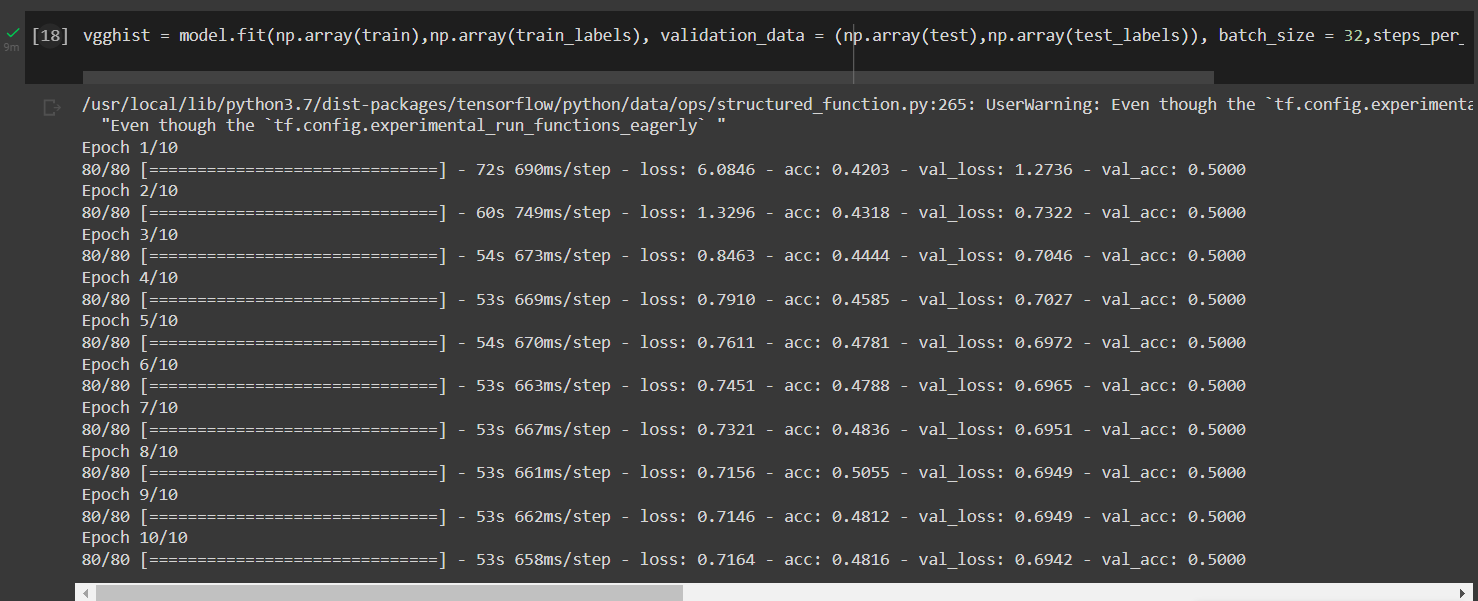


### The accuracy is not high as it is only 0.5 on the validation set

### This is due to the lack of data for the fitting part. As Colab run online, it was a challenge to feed and train the model.
### Colab processed the code faster, but as the repository is online it takes time and space in addition to that my wifi is very busy

In [19]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [31]:
# Set to predict
images = []
for i in range(200) :
    images.append(open_convert(d.iloc[i,4]))
    

In [32]:
pred = []

for i in range(200) : 
    pred.append(loaded_model.predict(images[i]))

C:\Users\pc\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [33]:
len(images)

200

In [34]:
for i in range(200) : 
    if pred[i][0][0] > 0.5 : 
        pred[i] = 1
    else: 
        pred[i] = 0

### 106 men and 94 women predicted

In [44]:
pred.count(1), pred.count(0)

(106, 94)

In [59]:
d['pred'] = pred

In [64]:
d['pred'] = d['pred'].replace(0,"female")
d['pred'] = d['pred'].replace(1,"male")


In [65]:
d.sample(n=20)

,firstname,lastname,label,location,profile_picture,pred
43,Rachel,Leist,Senior Director of Marketing at HubSpot,"Boston, Massachusetts, United States",https://media-exp2.licdn.com/dms/image/C4E03AQ...,male
174,Nathan,Hodge,Corporate Account Executive,"Portland, Maine, United States",https://media-exp1.licdn.com/dms/image/C5603AQ...,female
23,Mark,Roberge,ark Roberge - Managing Director - Stage 2 Capital,"Cambridge, Massachusetts, United States",https://media-exp2.licdn.com/dms/image/C4D03AQ...,female
3,Brian,Halligan,rian Halligan - Executive Chairperson,"Cambridge, Massachusetts, United States",https://media-exp2.licdn.com/dms/image/C4E03AQ...,male
79,Ryan,Batter,Director Corporate Strategy,Greater Boston,https://media-exp2.licdn.com/dms/image/C4E03AQ...,male
103,John,Eldridge,Corporate Growth Representative,"Boston, Massachusetts, United States",https://media-exp1.licdn.com/dms/image/C5603AQ...,female
19,Henry,Wu,NaN,"Washington, District of Columbia, United States",https://media-exp2.licdn.com/dms/image/C5103AQ...,male
109,Mali,R.,Channel Account Manager,"Milwaukee, Wisconsin, United States",https://media-exp1.licdn.com/dms/image/C4D03AQ...,female
184,Kevin,Ackhurst,NaN,Greater Boston,https://media-exp1.licdn.com/dms/image/C4D03AQ...,male
26,Jorie,Munroe,orie Munroe - Senior Inbound Professor,San Francisco Bay Area,https://media-exp2.licdn.com/dms/image/C5603AQ...,female


In [66]:
d.to_csv("data_employees_gender.csv")